In [1]:
%matplotlib inline

In [2]:
from __future__ import division
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.misc.pilutil import toimage
import sys
import numpy as np
import tensorflow as tf
from math import sqrt
import matplotlib.pyplot as plt

LEARNING_RATE = .001
PCA_COMPONENTS = 80
BATCH_SIZE = 64
TEST_BATCH_SIZE = 32
EPOCHS = 250

# color = true keeps color channels seperate
# with min_faces set to 14 - there will be 106 possible classifications
# image dimensions with param resize=0.5 will give 64x64 images
# people = fetch_lfw_people(
#     color=True,
#     resize=0.5,
#     slice_=(slice(61,189), slice(61,189)),
#     min_faces_per_person=14
# )
import _pickle as pickle

with open('people.pickle', 'rb') as f:
    people = pickle.load(f, encoding='iso-8859-1')

X = people.images
y = np.asarray(people.target, dtype=np.int32)

labels = people.target_names
n_classes = labels.shape[0]

To visualize, here's the dataset we're playing with

C:\Users\admin\Anaconda2\envs\project\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """


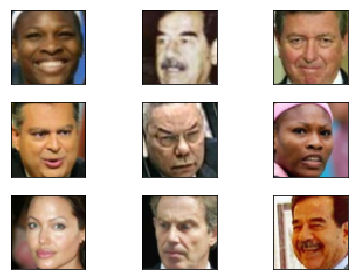

In [3]:
for i in range(0,9):
    d = plt.subplot(3, 3, i + 1)
    d.set_xticks([])
    d.set_yticks([])
    plt.imshow(toimage(X[i]))
    
plt.tight_layout()
plt.show()

In [21]:
def init_weights(shape):
    # Fix weight computation for RELU activations
    sigma = sqrt(2. / (1024 + 625))
    return tf.Variable(tf.random_normal(shape, stddev=sigma))



def model(X, w1, w2, w_fc, w_o, p_keep_conv, p_keep_hidden, act=tf.nn.relu, dropout=True):
    # First layer
    l1a = act(tf.nn.conv2d(X, w1, strides=[1, 1, 1, 1], padding='SAME'))

    l1 = tf.nn.max_pool(l1a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    l1 = tf.nn.dropout(l1, p_keep_conv) if dropout else l1

    # Second layer
    l2a = act(tf.nn.conv2d(l1, w2, strides=[1, 1, 1, 1], padding='SAME'))
    l2 = tf.nn.max_pool(l2a, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    l2 = tf.nn.dropout(l2, p_keep_conv) if dropout else l2

    # Flattening to feed through fully-connected layer
    l2 = tf.reshape(l2, [-1, w_fc.get_shape().as_list()[0]])    # reshape to (?, 8x8x64)

    # RELU feed-forward activation layer
    l3 = act(tf.matmul(l2, w_fc))
    l3 = tf.nn.dropout(l3, p_keep_hidden) if dropout else l3

    # Classification layer
    pyx = tf.matmul(l3, w_o)

    return pyx

def one_hot(target):
    labels = np.zeros(shape=(target.shape[0], target.max() + 1))
    for i, x in enumerate(target):
        labels[i][x] = 1

    return labels

We define the model as such 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

X_train /= X_train.max()
X_test /= X_test.max()

y_train = one_hot(y_train)
y_test = one_hot(y_test)

tX = tf.placeholder("float", [None, 64, 64, 3]) # 64, 64, 3 channels
tY = tf.placeholder("float", [None, 106]) # 106 output classes

w1 = init_weights([4, 4, 3, 64])
w2 = init_weights([6, 6, 64, 128])
w_fc = init_weights([128 * 16 * 16, 625])
w_o = init_weights([625, 106])

p_keep_conv = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(tX, w1, w2, w_fc, w_o, p_keep_conv, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x, labels=tY))
train_op = tf.train.RMSPropOptimizer(LEARNING_RATE, decay=.8).minimize(cost)
predict_op = tf.argmax(py_x, 1)

In [23]:
import time
accuracies = []

# tf.summary.histogram('conv_weights', w1)
# merged = tf.summary.merge_all()

# Launch the graph in a session
with tf.Session() as sess:
#     writer = tf.summary.FileWriter(".cnn\\lfw-data-%s" % time.ctime(), sess.graph)

    # you need to initialize all variables
    tf.global_variables_initializer().run()
    
    for i in range(EPOCHS):
        training_batch = zip(range(0, len(X_train), BATCH_SIZE),
                             range(BATCH_SIZE, len(X_train) + 1, BATCH_SIZE))
        for start, end in training_batch:
            sess.run(train_op, feed_dict={
                tX: X_train[start:end],
                tY: y_train[start:end],
                p_keep_conv: 0.8,
                p_keep_hidden: 0.5
            })

        test_indices = np.arange(len(X_test))  # Get A Test Batch
        np.random.shuffle(test_indices)
        test_indices = test_indices[0:TEST_BATCH_SIZE]

        res = sess.run(predict_op, feed_dict = {
            tX: X_test[test_indices],
            p_keep_conv: 1.0,
            p_keep_hidden: 1.0
        })
        sub = y_test[test_indices]
        acc = np.mean(np.argmax(sub, axis=1) == res)
        accuracies.append(acc)
        # writer.add_summary(summary, i)
        print(i, acc)

    test_indices = np.arange(len(X_test))  # Get A Test Batch
    np.random.shuffle(test_indices)
    test_indices = test_indices[0:TEST_BATCH_SIZE]
    res = sess.run(predict_op, feed_dict = {
        tX: X_test[test_indices],
        p_keep_conv: 1.0,
        p_keep_hidden: 1.0
    })    
    plt.figure(figsize=(60, 60))
    print('Prediction')
    for j in range(0,9):
        d = plt.subplot(1, 9, j + 1)
        d.set_xticks([])
        d.set_yticks([])
        plt.imshow(toimage(X[res[j]]))
    plt.tight_layout()
    plt.show()
    print('Actual')
    plt.figure(figsize=(60, 60))

    for j in range(0,9):
        d = plt.subplot(1, 9, j + 1)
        d.set_xticks([])
        d.set_yticks([])
        plt.imshow(toimage(X[np.argmax(sub[j])]))
    plt.tight_layout()
    plt.show()

0 0.125
1 0.0625
2 0.21875
3 0.3125
4 0.3125
5 0.3125
6 0.40625
7 0.5625
8 0.5625
9 0.5625
10 0.53125
11 0.5
12 0.53125
13 0.65625
14 0.59375
15 0.75
16 0.625
17 0.6875
18 0.65625
19 0.75
20 0.6875
21 0.65625
22 0.5625
23 0.65625
24 0.59375
25 0.625
26 0.59375
27 0.5
28 0.65625
29 0.59375
30 0.59375
31 0.6875
32 0.625
33 0.53125
34 0.65625
35 0.625
36 0.75
37 0.75
38 0.53125
39 0.6875
40 0.75
41 0.65625
42 0.46875
43 0.625
44 0.53125
45 0.625
46 0.625
47 0.75
48 0.6875
49 0.6875
50 0.625
51 0.8125
52 0.59375
53 0.59375
54 0.71875
55 0.65625
56 0.53125
57 0.6875
58 0.71875
59 0.71875
60 0.65625
61 0.59375
62 0.59375
63 0.625
64 0.6875
65 0.6875
66 0.71875
67 0.75
68 0.625
69 0.6875
70 0.625
71 0.75
72 0.6875
73 0.75
74 0.5
75 0.625
76 0.71875
77 0.71875
78 0.65625
79 0.75
80 0.6875
81 0.5625
82 0.65625
83 0.6875
84 0.53125
85 0.71875
86 0.71875
87 0.75
88 0.625
89 0.71875
90 0.75
91 0.75
92 0.59375
93 0.6875
94 0.65625
95 0.6875
96 0.6875
97 0.6875
98 0.8125
99 0.65625
100 0.625
101 0.7

KeyboardInterrupt: 

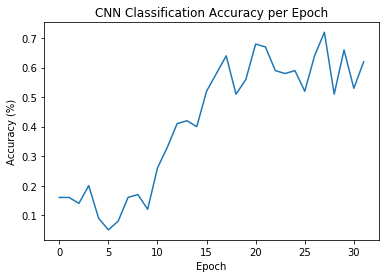

In [17]:
# Plot accuracy
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title("CNN Classification Accuracy per Epoch")
plt.show()

In [ ]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    res = session.run(predict_op, feed_dict = {
        tX: X_test[[range(100)]],
        p_keep_conv: 1.0,
        p_keep_hidden: 1.0
    })
    print(np.mean(np.argmax(y_test[range(100)]) == res))